# Tarea 3: Redes Convolucionales

En esta tarea utilizarás neuronales convolucionales para reconocer dígitos y operaciones matemáticas en imágenes.

## Contexto

Hace unos meses, Apple lanzó una aplicación llamada *Math Notes* ([link](https://www.apple.com/newsroom/2024/06/ipados-18-introduces-powerful-intelligence-features-and-apps-for-apple-pencil/)). Entre otras cosas, esta aplicación permite reconocer ecuaciones escritas a mano y resolverlas.

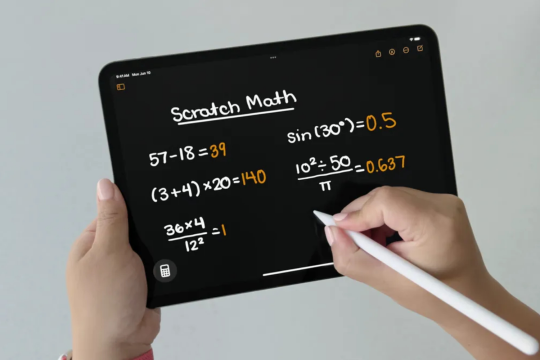


Deep learning fue clave en este avance tecnológico. Usando grandes volúmenes de datos, una red convolucional fue capaz de reconocer los dígitos escritos por el usuario. Luego, se resuelve la ecuación y se escribe el resultado en la pantalla.

En esta tarea vamos a dar un paso hacia replicar la aplicación hecha por Apple. Vamos a entrenar una red convolucional que sea capaz de reconocer dígitos y operaciones matemáticas a partir de imágenes.

<!-- **Objetivo:** Esta tarea tiene como objetivo principal familiarizarlos con el manejo y análisis de datos en un contexto de aprendizaje profundo, específicamente utilizando redes neuronales convolucionales (CNN). Además, se enfoca en el desarrollo de habilidades críticas para identificar y solucionar problemas en la arquitectura de una red neuronal.

**Pasos a Seguir:**

1. **Análisis Preliminar de los Datos:**
   - **Identificación de Clases**: Investiguen cuántas clases diferentes están presentes en el conjunto de datos, será necesario para poder construir la arquitectura de la red.

   - **Balance de Datos**: Determinen si los datos están balanceados entre estas clases. ¿Hay una cantidad similar de ejemplos para cada clase?
   ¿Tienen el mismo tamaño todas las imagens?

   - **Exploración de Canales de Color**: Examinen los canales de color de las imágenes. ¿Están en RGB, escala de grises, o algún otro formato?

2. **Revisión y Corrección del Código:**
   - **Lectura Detenida del Código**: Dediquen tiempo a leer cuidadosamente el código proporcionado. Noten que hay partes incompletas o errores que deberán ser capazes de identificar.

   - **Implementación de Soluciones**: Basándose en los comentarios y en su comprensión del problema, completarán las partes faltantes del código.

3. **Tareas Específicas en la Arquitectura de la Red:**
   - **Mantenimiento de la Arquitectura Base**: La evaluación se centrará en si son capaces de completar correctamente la arquitectura de la red comparada con la solución.
   - **Ajuste de la Arquitectura**: Aunque no necesitarán manejar hiperparámetros de entrenamiento, sí deberán ajustar aspectos de la arquitectura de la red. Esto incluye calcular las dimensiones correctas en las diferentes capas para asegurarse de que la red esté bien configurada.

   - **Identificación de Transformaciones de Datos**: Tendrán que indentificar tres transformaciones que se deben aplicar a los datos para que el modelo funcione correctamente. Estas transformaciones pueden estar relacionadas con el preprocesamiento o la mejora de los datos.

**Evaluación:**

La evaluación se basará en la correcta implementación de la arquitectura de la red, la adecuada identificación y solución de los errores en el código, y la implementación efectiva de las transformaciones de datos necesarias. -->

## Preprocesamiento de datos

Como en toda aplicación de deep learning, lo primero es analizar los datos que tenemos. El archivo **dataset_digits.zip** contiene varias carpetas con ejemplos de cada una de las clases.

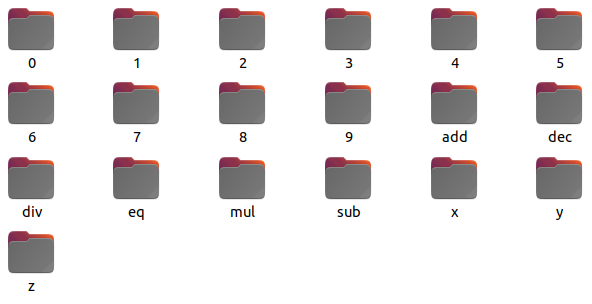


Al analizar los datos te darás cuenta que este dataset presenta tres desafíos.

El primero es que, a diferencia de otros datasets, no existe un set de testeo predefinido. Será necesario que nosotros formemos uno para poder evaluar la generalización de nuestro modelo.

El segundo es que las clases están desbalanceadas. Por ejemplo, para la clase "0" existen 595 ejemplos, mientras que para la clase "Z" hay 212 ejemplos.

El último desafío es que, a veces, las imágenes tienen distinta dimensión. Por ejemplo, acá hay dos instancias de la clase "x" dentro del dataset. Una de ellas es de 400x400 pixeles mientras que la otra es de 155x135 pixeles:

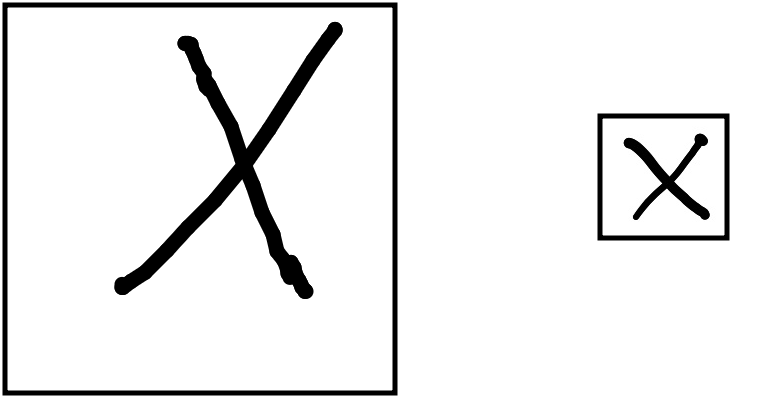

Que las imágenes sean de distinta dimensión es problemático porque las redes neuronales aceptan inputs de tamaño fijo. Es decir, o siempre aceptan imágenes de 400x400 o de 155x135 o de 100x100.

### Manos a la obra

Comencemos a trabajar. Partamos descomprimiendo el dataset.

In [1]:
!pip -q install torch torchvision
!pip -q install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os

path_file = 'dataset_digits'

if not os.path.exists(path_file):
    os.system('unzip -q dataset_digits.zip')

Ahora importamos torch y librerías auxiliares que nos permitirán preprocesar los datos.

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

El método de abajo hace lo siguiente:

1.   Utiliza `datasets.ImageFolder(...)` para cargar el dataset (ver [documentación](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)).
2.   Luego utiliza `random_split(...)` para separar el dataset en un grupo de entrenamiento y en un grupo de testeo. Por defecto, el 80% de los datos se usan para entrenar y el 20% restante para testear (ver [documentación](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)).
3.   Finalmente, utiliza `DataLoader(...)` para dividir aleatoriamente los datasets de entrenamiento y testeo en batches de 128 ejemplos cada uno (por defecto) (ver [documentación](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)).

Notar que `datasets.ImageFolder(...)` recibe `transform` como parámetro. Este argumento nos permite preprocesar los datos al momento en que los leemos. En particular,
```
transform = transforms.Compose([...])
```
... crea una secuencia de transformaciones que son aplicadas a las imágenes de input. Este es el lugar ideal para hacer cuatro preprocesamientos claves en nuestra aplicación:

1.   Estandarizar el tamaño de las imágenes. En particular, debes escalar las imágenes a 100x100 pixeles.
2.   Pasar las imágenes a escala de grises. Esto tiene sentido porque las imágenes son en blanco y negro pero, por defecto, `datasets.ImageFolder(...)` las carga como si fuesen imágenes a color. Es decir, tienen intensidades en rojo, verde y azul. Transformar las imágenes a escala de grises permite trabajar con una sola intensidad -- reduciendo el cómputo necesario para entrenar la red.
3.   Transformar las imágenes a tensores. Para dar cualquier input a una red en torch hay que transformarla a tensor. Por lo mismo, es usual transformar las imágenes a tensores al momento de leer el dataset.
4.   Normalizar las imágenes para que la intensidad media de sus pixeles sea 0.5 y su desviación estándar también sea 0.5. Como vimos en clase, normalizar los datos ayuda mucho a mejorar el rendimiento de una red neuronal.

El código ya realiza la transformación a tensores. Tu trabajo incluye agregar las otras 3 transformaciónes (donde el orden importa). Para ello, puedes ver la documentación con las transformaciones que existen en torch: [Documentación](https://pytorch.org/vision/0.9/transforms.html).

In [4]:
def load_and_split_dataset(data_dir, batch_size=128, train_split=0.8):

    transform = transforms.Compose([

        # Agrega transformaciones para escalar las imágenes y pasar a escala de grises
        # your code here
        transforms.Resize(size=(100,100)),
        transforms.Grayscale(),

        transforms.ToTensor(),
        # Agrega una transformación para normalizar la imagen
        transforms.Normalize(mean=0.5, std=0.5)
        
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset= random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, transform


Gracias a todo nuestro trabajo, ahora podemos leer el dataset y preprocesar los datos simplemente llamando a `load_and_split_dataset(...)`:

In [10]:
train_loader

128

In [5]:
data_dir = 'dataset_digits'  # Ruta donde se encuentra el dataset
train_loader, test_loader, transform = load_and_split_dataset(data_dir)

## Crear una red convolucional

Una de las mayores dificultades al usar redes convolucionales es definir su arquitectura. Definir la arquitectura de una red convolucional es más difícil que definir la arquitectura de una red multicapa. Las convoluciones distorsionan el input, muchas veces disminuyendo su tamaño. Estas distorsiones deben ser consideradas al momento de definir las siguientes capas.

Por ejemplo, al aplicar un filtro de 3x3 con stride de 1 (y sin padding) a una imagen de 5x5, el resultado es una nueva "imagen" (técnicamente, son activaciones de neuronas puestas en una cuadrilla -- llamada *mapa de features*) de 3x3.

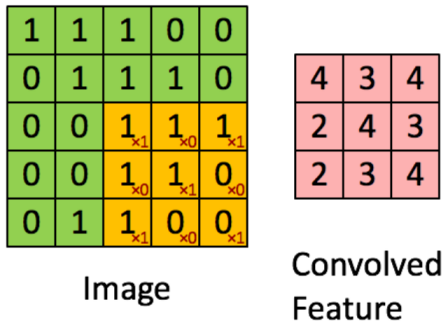


### Convoluciones

En general, las convoluciones son aplicadas a imágenes (o mapas de features) modelados en 3 dimensiones. Por ejemplo, una imagen a color de 32x32 pixeles se modela como un *tensor* de 32x32x3 (donde el 3 hace referencia a los valores de rojo, verde y azul del pixel). Por otro lado, una imagen de 32x32 pixeles en escala de grises se modela como un tensor de 32x32x1.

Digamos que queremos aplicar una convolución de 5x5 sobre la imagen a color. Para ello, hay algunas decisiones que debemos tomar. La primera es definir el tamaño del **kernel**. El kernel es el tamaño de la convolución (o filtro), que ya habíamos decido sería de 5x5. Es decir, el kernel es 5.

Luego hay que definir los **in_channels**. Esto se refiere al número de canales de input, que es igual a la tercera dimensión del mapa de features sobre el que se aplica la convolución. Por ejemplo, si la convolución se aplica sobre una imagen a color, el in_channels tiene que ser 3.

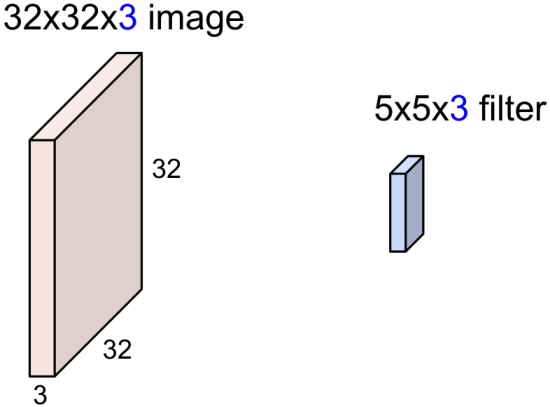

Luego hay que definir el **stride** y el **padding**. Lo más común es usar stride de 1 y padding de 0. Esto significa que la convolución se aplica a un cuadrante de la imagen y luego nos movemos un espacio al lado y la volvemos a aplicarla. Esto continúa hasta pasar por toda la imagen.

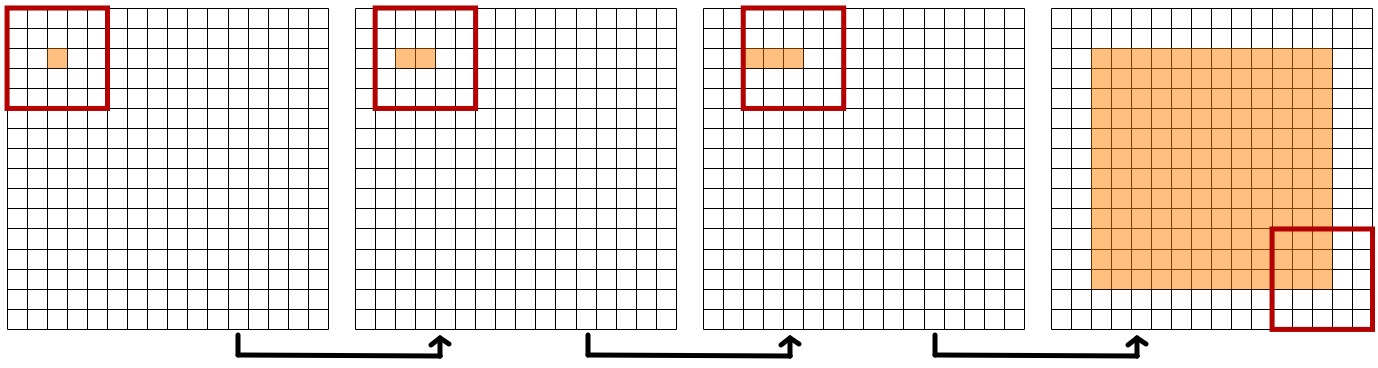



El resultado de aplicar la convolución de 5x5 usando stride de 1 y padding de 0 es que la imagen se achica. Se pierden dos pixeles al rededor de la imagen. Por lo mismo, si la imagen de entrada era de 32x32, el mapa de features de salida (luego de aplicada la convolución) es de 28x28.

Es posible controlar las dimensiones de la salida cambiando el stride y el padding. El stride indica cuánto avanzamos luego de realizar cada convolución. Por ejemplo, un stride de 2 significa que haremos una convolución sobre un cuadrante de la imagen y luego nos moveremos dos espacios para realizar la siguiente convolución.

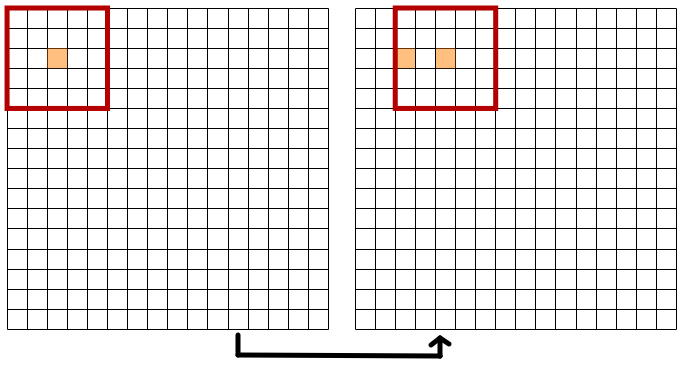

Por un lado, usar un stride más alto hace que la "imagen" de salida sea más pequeña. La ventaja de esto es que se aplican menos convoluciones, haciendo que el entrenamiento y testeo sea más rápido. Lo malo, es que se pierde resolución.

En particular, si aplicamos una convolución de 5x5 sobre una imagen de 32x32 con stride de 2, el resultado será de 14x14.

Por otro lado, utilizar padding permite evitar que el tamaño de la imagen disminuya luego de la convolución. Padding no es otra cosa que agregar un margen de *ceros* al rededor de la imagen.

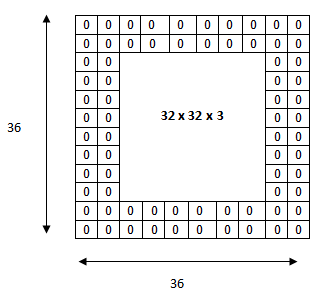

Padding permite reducir la disminución en el tamaño de la imagen luego de aplicar una convolución. Por ejemplo, una convolución de 5x5 sobre una imagen de 32x32 pasa a ser una imagen de 28x28 si usamos stride de 1 sin padding. Pero si usamos padding de 2, la imagen resultante sigue siendo de 32x32.

Para calcular la dimensión de salida de una capa convolucional se puede usar la siguiente fórmula:

$ \text{Dimensión de salida} = \left\lfloor \frac{\text{Dimensión de entrada} - \text{Kernel} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1 $

Donde:
- **Dimensión de entrada** es el tamaño (ancho o alto) de la imagen o mapa de featurs de entrada.
- **Kernel** es el tamaño del kernel (o filtro) que estás utilizando.
- **Stride** es el paso con el que se mueve el filtro sobre la imagen.
- **Padding** es la cantidad de ceros que se añade alrededor de la entrada.

Por ejemplo, si la entrada es de 32x32 (ancho x alto), el kernel es de 3, el stride es 1 y el padding es 0, entonces la dimensión de salida es 30:

$ \text{Dimensión de salida} = \left\lfloor \frac{32 - 3 + 2 \times 0}{1} \right\rfloor + 1 = 30 $

(Notar que la fórmula anterior asume que el input es una imagen cuadrada. Si este no es el caso, hay que aplicar la misma fórmula pero a cada dimensión por separado.)

El último elemento que debemos definir de una convolución son sus **out_channels**. Este es el número de canales de salida que tendrá la convolución. Por ejemplo, ya sabemos que la salida de aplicar un filtro de 5x5 (con stride 1 y sin padding) sobre una imagen de 32x32x3 es de 28x28. Sin embargo, la salida no es solo eso. La salida también tiene una tercera dimensión que es igual al out_channels de la convolución. Por ejemplo, si el out_channels es 5, entonces la salida será de 28x28x5.

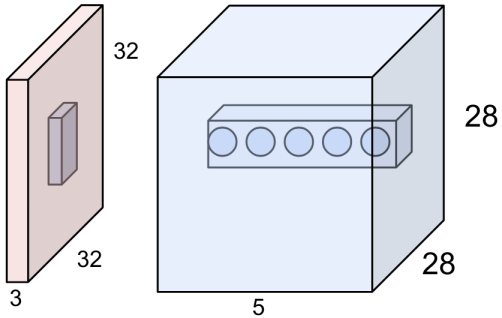

Intuitivametne, los out_channels representan el número de filtros que dejaremos que la red aprender para resolver este problema. Por ejemplo, si out_channels es 5, dejaremos que descenso de gradiente aprenda 5 filtros distintos (a partir del input) en esta convolución.

Definir el valor de out_channels se parece a definir el tamaño de una capa oculta en una red multicapa. Mientras más grande, más capacidad tiene el modelo. Pero, al mismo tiempo, implica tener que aprender más parámetros.

### Pooling

Las redes convolucionales, además de tener capas covolucionales, tienen capas de pooling. Estas capas reducen la dimensionalidad de los mapas de features mediante reemplazar cuadrantes completos por alguna estadística de ellos. Por ejemplo, su promedio o su valor máximo.

En redes convolucionales se suele ocupar **max pooling**. Esto es, tomar el máximo valor dentro de cada cuadrante de la imagen (o mapa de features) de entrada. Por ejemplo, acá dividimos la imagen en cuadrantes de 2x2 y realizamos max pooling:

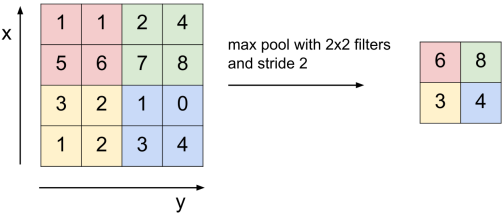


Al igual que con las convoluciones, una capa de max pooling también debe definir el tamaño de su kernel y su stride. Para calcular el tamaño de la salida se puede utilizar la siguiente ecuación:

$ \text{Dimensión de salida} = \left\lfloor \frac{inputSize - kernel }{stride} \right\rfloor +1 $

Por ejemplo, si la entrada a la capa de max pooling es de 30x30x5, el kernel es 2 y el stride es 2, entonces la salida de max pooling es de 15x15x5.

Notar que las capas de pooling siempre mantienen el número de canales de salida.


### Capa fully connected

Las redes convolucionales suelen terminar con 2 o 3 capas fully connected. Esto permite transformar la salida de la red en un vector unidimensional. Por ejemplo, en un problema de clasificación con 10 clases posibles, las capas fully connected permiten que la salida sea un vector de tamaño 10 (i.e., una neurona por clase).

Para que esto funcione, el último mapa de features tridimensional -- es decir, la salida de la última capa convolucional -- debe ser transformado en un vector unidimensional. Hacer esto es trivial. Basta con poner todos los valores del tensor *en fila*. El verdadero problema es hacer que las dimensiones calcen.

Por ejemplo, si luego de aplicadas todas las convoluciones (y poolings) nos queda un tensor de 7x7x512, al pasarlo a un vector unidimensional su tamaño es igual a $7 \cdot 7 \cdot 512 = 25088$. Conocer ese número nos permite definir la dimensión de entrada de la primera capa fully connected.

Es por este motivo que debemos ser capaces de entender cómo las dimensiones de la imagen van cambiando a medida que pasan por capas convolucionales y de max pooling.

Por ejemplo, digamos que el input de la red son imágenes de 10x10x3. La red tiene una capa convolucional con filtros de 3x3, stride de 1, padding 0 y 6 out_channels. Luego tiene una capa de max pooling con un kernel de 2 y stride de 2. ¿De qué dimensión es el tensor de entrada a la primera capa fully connected?

Si seguimos las ecuaciones anteriores podemos calcularlo. La entrada de la red es de 10x10x3. Luego de la primera convolución:

$ \text{Dimensión de salida} = \left\lfloor \frac{10 - 3 + 2 \times 0}{1} \right\rfloor + 1 = 8 $

... la salida nos queda de 8 x 8 x 6. Esta salida es dada a la capa de max pooling, que vuelve a reducir la dimensión:

$ \text{Dimensión de salida} = \left\lfloor \frac{8 - 2 }{2} \right\rfloor +1 = 4$

... es decir, el tensor final es de 4 x 4 x 6. Por lo mismo, la entrada a la primera capa fully connected es un vector de $4 \cdot 4 \cdot 6 = 96$ features.




### Manos a la obra



<!-- Las convoluciones son definidas a partir de 5 valores.

**Kernel**:


Para calcular la dimensión de salida de una capa convolucional en una red neuronal, puedes usar la siguiente fórmula:

$ \text{Dimensión de salida} = \left\lfloor \frac{\text{Dimensión de entrada} - \text{Kernel} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1 $

Donde:
- **Dimensión de entrada** es el tamaño (ancho o alto) de la imagen o mapa de características de entrada.
- **Kernel** es el tamaño del kernel (o filtro) que estás utilizando.
- **Stride** es el paso con el que se mueve el filtro sobre la imagen.
- **Padding** es la cantidad de relleno que se añade alrededor de la entrada.
- **Output Channel** es la cantidad de filtros que vamos crear.

Esta fórmula se aplica tanto para el ancho como para el alto de la imagen o mapa de características de entrada, suponiendo que el stride y el padding son iguales en ambas dimensiones.

Por ejemplo, si tienes una entrada de 32x32 (ancho x alto), un kernel de tamaño 3, un stride de 1 y un padding de 0, la dimensión de salida sería:

$ \text{Dimensión de salida} = \left\lfloor \frac{32 - 3 + 2 \times 0}{1} \right\rfloor + 1 = 30 $

Así que obtendrías una salida de 30x30xOutput Channel.


Recuerda que esta fórmula asume que estás trabajando con imágenes cuadradas y que el stride y el padding son iguales en ambas dimensiones. En casos más complejos, tendrías que aplicar la fórmula por separado para cada dimensión.

Lo mismo será valido para el Max Pooling, pero acá debemos usar
$ \text{Dimensión de salida} = \left\lfloor \frac{inputSize - kernel }{stride} \right\rfloor +1 $

Así que por ejemplo, si tenemos que la salida anterior es 30x30, kernel = 2, stride = 2

$ \text{Dimensión de salida} = \left\lfloor \frac{30 - 2 }{2} \right\rfloor +1 = 15$ como para nuestro caso la imagen tiene dimensiones cuadradas 15x15xOutput Channel esto seria la dimensión de salida.

 .

Así que por ejemplo:

Sea el vector de entrada con 10x10 (ancho x alto) y 3 canales de color,
si tenemos una convolución que retorna 6 filtros, con tamaño de kernel =3x3, stride=1, padding =0

$ \text{Dimensión de salida} = \left\lfloor \frac{10 - 3 + 2 \times 0}{1} \right\rfloor + 1 = 8 $ dimensión total = 8 x 8 x 6

si aplicamos un Max pooling de kernel=2, stride=2

$ \text{Dimensión de salida} = \left\lfloor \frac{8 - 2 }{2} \right\rfloor +1 = 4$ dimensión total = 4 x 4 x 6


Esto nos va servir para calcular correctamente la dimensión de la capa feedfoward, que debe ser igual a la dimensión de salida de la última capa convolucional. -->

Llegó el momento de definir una red convolucional para resolver el problema de reconocimiento de símbolos matemáticos. Abajo, te proveemos el esqueleto de una red convolucional. Esta red está incompleta. Tu trabajo es agregar las cosas que faltan.

En particular, debes realizar los siguientes cambios a la red (los lugares que debes cambiar están marcados en el código):

*   La primera convolución tiene un error en uno de sus parámetros.
*   Agrega una capa convolucional.
*   Define la dimensión del vector de entrada de la primera capa fully connected.
*   Agrega la capa de salida.

... una vez que realices estos cambios serás capaz de entrenar esta red convolucional para reconocer dígitos y símbolos matemáticos :)

In [46]:
import torch
import torch.nn as nn

class AlexNetModified(nn.Module):
    def __init__(self, dropout: float = 0.5) -> None:
        super().__init__()

        # Parámetros primera capa convolucional (el valor de uno de ellos es incorrecto)
        in_channels = 3
        out_channels = 32
        kernel_size = 9
        stride = 3
        padding = 2

        # Acá abajo arregla el valor del parámetro incorrecto.
        # HINT: El parámetro es incorrecto debido a que el input de la red es
        #       una imagen en escala de grises (de 100x100x1)
        
        in_channels=1
        
        self.features = nn.Sequential(

            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride, padding=padding), #output de 32x32x32

            nn.ReLU(inplace=True), # output 32x32
            nn.MaxPool2d(kernel_size=3, stride=2), # output 15x15x32

            nn.Conv2d(in_channels=32, out_channels=96, kernel_size=5, padding=2), # output 15x15x96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # output 7x7x96

            # Acá falta una capa convolucional con kernel_size=3, padding=1.
            # ¿Cuáles son sus in_channels y out_channels?
            
            nn.Conv2d(in_channels=96,
                      out_channels=192,
                      kernel_size=3,
                      stride=1, padding=1),  # output 7x7x192
            
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, padding=1), # output 7x7x128
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # output 7x7x128
            nn.ReLU(inplace=True),

        )

        # En esta variable hay que guardar la dimensión del vector de entrada
        # a la primera capa fully connected
        dimension_capa_fully_connected = None
        # ¿Cuál es la dimensión de este vector?
        # Abajo debes asignar el valor correcto a dimension_capa_fully_connected
        # your code here
        dimension_capa_fully_connected = 7*7*128
        self.classifier = nn.Sequential(

            nn.Dropout(p=dropout),
            nn.Linear(dimension_capa_fully_connected, int(512)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(int(512), int(512)),
            nn.ReLU(inplace=True),
            # Agrega la capa de salida
            # ¿cuántas neuronas de salida debería tener nuestra red?
            # your code here
            
            nn.Linear(int(512), int(19)),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## Testeando tu solución

Para verificar que tu solución sea correcta, ejecuta las celdas de abajo.

In [33]:
# Resize


In [34]:
# Grayscale


In [35]:
# Test transformaciones


In [36]:
# Test primera capa covolucional


In [37]:
# Test capa convolucional intermedia


In [38]:
# Tests capa lineal


In [39]:
# Tests de estructura del clasificador


## Entrenar la red convolucional

Si lograste pasar los tests anteriores, felicitaciones. Has completado esta tarea. Eso significa que entiendes los elementos claves que permiten definir una red convolucional. El resto, entrenar la red, es idéntico a entrenar una red multicapa. Por ese motivo, no tiene mucho sentido volver a evaluar que puedas entrenar la red correctamente.

Dicho eso, esta actividad no puede terminar así. Tenemos que verificar que nuestro esfuerzo valió la pena. Tenemos que ver que efectivamente la red convolucional puede resolver nuestro problema de reconocimiento de dígitos y símbolos matemáticos.

Para ello, vamos a probar tu código haciendo uso de GPU.

El método `train_model(...)` es un código estándar que permite entrenar un modelo dado un set de entrenamiento (`train_loader`), set de validación (`valid_loader`), una función de pérdida (`criterion`) y un optimizador. Además, utilizará una GPU.

In [40]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=5):
    model.to(device)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    return model

Ahora vamos a crear una instancia de la red neuronal que definimos durante esta actividad. Usaremos como función de pérdida cross-entropy y el optimizador será Adam con un learning rate de 0.001. Luego, entrenamos nuestra red.

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetModified()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5)

Epoch 1/5, Train Loss: 4.0398, Validation Loss: 3.4690
Epoch 2/5, Train Loss: 3.4166, Validation Loss: 2.6331
Epoch 3/5, Train Loss: 1.9945, Validation Loss: 1.2441
Epoch 4/5, Train Loss: 1.0918, Validation Loss: 0.6354
Epoch 5/5, Train Loss: 0.4338, Validation Loss: 0.2399


In [42]:
def predict_and_evaluate(model, data_loader, device):
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for inputs, true_labels in data_loader:
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.view(-1).cpu().numpy())
            labels.extend(true_labels.view(-1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return predictions, labels, accuracy, precision, recall, f1

def show_predictions(data_loader, predictions, labels, class_names, num_images=10):
    plt.figure(figsize=(12, 8))

    for i in range(num_images):
        inputs, _ = next(iter(data_loader))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(inputs[i][0], cmap='gray')  # assuming grayscale images
        plt.title(f'Pred: {class_names[predictions[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')

    plt.show()

Una vez entrenada la red, podemos evaluar su rendimiento en el set de test. Si todo salió bien, el rendimiento debería ser sobre el 90%. Nada mal para ser nuestra primera red convolucional ;)

In [43]:
model = trained_model.to(device)  # Your trained model

# Get predictions and metrics
predictions, labels, accuracy, precision, recall, f1 = predict_and_evaluate(model, test_loader, device)
# Print metrics
print(f'Accuracy for real model: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy for real model: 0.9266, Precision: 0.9303, Recall: 0.9266, F1-Score: 0.9271


Finalmente, podemos visualizar algunos ejemplos de tests con sus clases correctas y la predicción hecha por nuestra red.

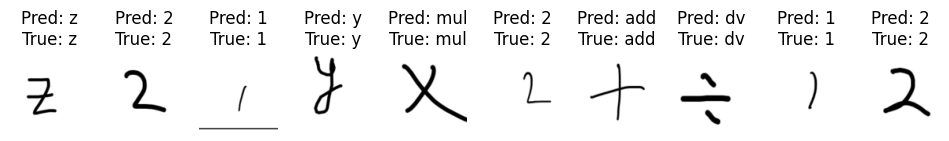

In [44]:
# Assuming you have a list of class names
class_names = ['0', '1', '2', '3', '4', '5', '6', '7','8', '9', 'add', 'dec', 'dv', 'eq', 'mul', 'sub', 'x', 'y', 'z']

# Display some predictions
show_predictions(test_loader, predictions, labels, class_names)